## Loading MNIST dataset

In [1]:
import pandas as pd
train = pd.read_csv("../Datasets/MNIST/train.csv")
test = pd.read_csv("../Datasets/MNIST/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
import numpy as np
x = np.array(train.drop('label', axis = 1))
y = np.array(train.label)
print(x.shape, y.shape)

(42000, 784) (42000,)


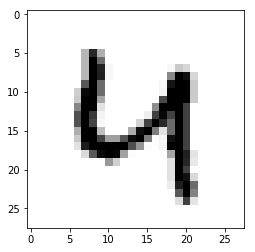

Label:  4


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[420]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
plt.show()
print("Label: ", y[420])

In [4]:
shuffled_indices = np.random.permutation(x.shape[0])
x_train, y_train = x[shuffled_indices], y[shuffled_indices]

## A simple binary classifier and its evaluation
### "4- detector", (4 or not-4)

In [5]:
y_train_4 = (y_train == 4) #true when label is 4, false otherwise

In [6]:
#To remove sklearn's Future warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(x_train, y_train_4):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train_4[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train_4[test_index])
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9742875508892223
0.9701428571428572
0.9673548110579328


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_4, cv = 3, scoring = "accuracy")

array([0.97428755, 0.97014286, 0.96735481])

In [11]:
#Dumb Classifier:

from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype = bool)

nvr4clf = Never4Classifier()
cross_val_score(nvr4clf, x_train, y_train_4, cv = 3, scoring = "accuracy")

array([0.90164286, 0.90378571, 0.90371429])

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_4, cv = 3)

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_4, y_train_pred)

array([[37321,   607],
       [  628,  3444]], dtype=int64)

In [14]:
from sklearn.metrics import precision_score, recall_score

print("Classifier is correct {}% of the time".format(precision_score(y_train_4, y_train_pred)*100))
print("Classifier detects {}% of the 4s".format(recall_score(y_train_4, y_train_pred)*100))

Classifier is correct 85.01604542088373% of the time
Classifier detects 84.57760314341847% of the 4s


In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_4, y_train_pred)

0.8479625754031762

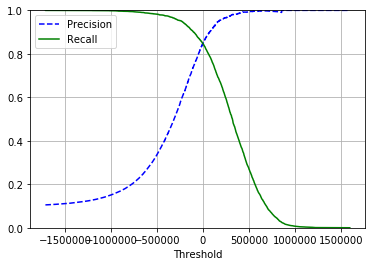

In [16]:
#precision-recall trade-off
#plotting precision-recall curve to determine threshold

y_scores = cross_val_predict(sgd_clf, x_train, y_train_4, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim(0, 1)
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

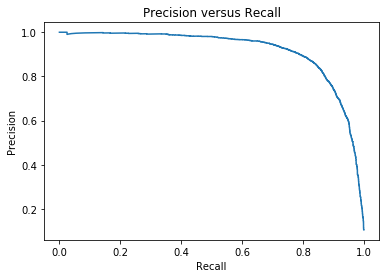

In [17]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision versus Recall")
plt.show()

In [18]:
#for ~90% precision:

y_train_pred_90 = (y_scores > 80000)
print("Precision: ", precision_score(y_train_4, y_train_pred_90))
print("Recall: ", recall_score(y_train_4, y_train_pred_90))

Precision:  0.9051944365597502
Recall:  0.7831532416502947


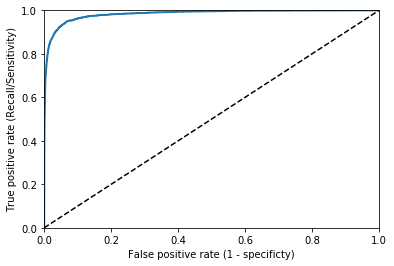

In [19]:
#ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate (1 - specificty)')
    plt.ylabel('True positive rate (Recall/Sensitivity)')

plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
#ROC AUC score:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_4, y_scores)

0.983535109849331

In [21]:
#Random forest classifier:

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_4, cv = 3, method="predict_proba")

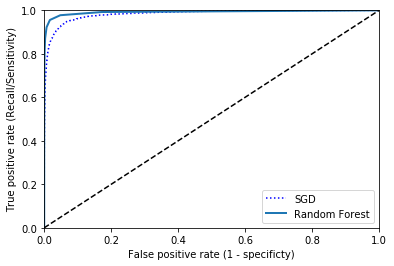

In [22]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

In [23]:
roc_auc_score(y_train_4, y_scores_forest)

0.9922844161297861

## Multiclass classification

In [24]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=int64)

In [25]:
#10 scores per instance (OVA Strategy)

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-542820.41171688, -825528.78097461, -525593.0446124 ,
        -610754.78670145,  283780.60226267, -871044.11932645,
        -241970.96366663, -415111.43896078,   95686.54335779,
        -257132.17506256]])

In [26]:
np.argmax(some_digit_scores)

4

In [27]:
#forced OVO strategy:

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=int64)

In [28]:
len(ovo_clf.estimators_)

45

In [29]:
#random forest classifier (doesn't requires either of OVO or OVA strategy):

forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

array([4], dtype=int64)

In [30]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. , 0. ]])

In [31]:
cross_val_score(sgd_clf, x_train, y_train, cv = 3, scoring="accuracy")

array([0.87717795, 0.86105158, 0.87705386])

In [32]:
#scaling the inputs for better accuracy:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))

cross_val_score(sgd_clf, x_train_scaled, y_train, cv = 3, scoring="accuracy")

array([0.90959726, 0.91191599, 0.90684383])

In [33]:
#error analysis

y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

array([[4009,    0,   16,    9,    8,   26,   39,    4,   20,    1],
       [   0, 4510,   30,   24,    3,   15,    8,    7,   82,    5],
       [  33,   25, 3730,   78,   57,   18,   62,   48,  111,   15],
       [  27,   26,  102, 3794,    3,  148,   29,   36,  118,   68],
       [   9,   24,   28,    6, 3731,    7,   34,   22,   51,  160],
       [  65,   36,   25,  144,   55, 3157,   73,   27,  146,   67],
       [  32,   15,   22,    0,   23,   71, 3941,    7,   26,    0],
       [  23,   13,   54,   18,   26,    6,    4, 4064,   11,  182],
       [  37,   89,   41,  109,    9,   88,   35,   18, 3547,   90],
       [  40,   19,   13,   61,  118,   18,    1,  141,   63, 3714]],
      dtype=int64)

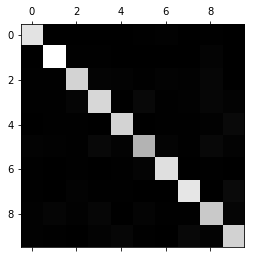

In [34]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

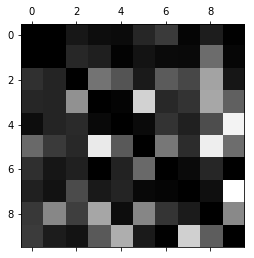

In [35]:
row_sums = np.sum(conf_mx, axis = 1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

#filling the diagonals with 0 to keep only errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

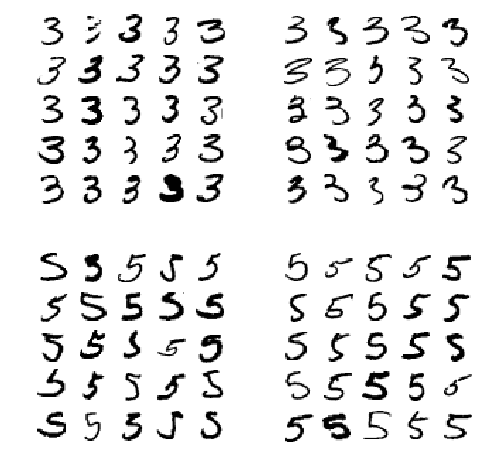

In [36]:
#plotting 3s and 5s

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5

x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row = 5)
plt.show()


## Multilabel classification

In [37]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
knn_clf.predict([some_digit]) #4<7 and not odd

array([[False, False]])

## Multiclass classification
### Illustration will remove noise from images

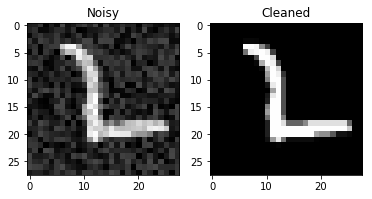

In [59]:
some_index = 420
noise = np.random.randint(0, 100, (len(x_train), 784))

x_train_mod = x_train + noise
y_train_mod = x_train

fig = plt.figure()
plt.subplot(121); plt.imshow(x_train_mod[some_index].reshape(28, 28), cmap = plt.cm.gray)
plt.title('Noisy')
plt.subplot(122); plt.imshow(x_train[some_index].reshape(28, 28), cmap = plt.cm.gray)
plt.title('Cleaned')
plt.show()


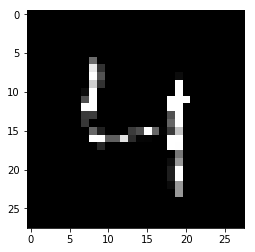

In [61]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit])
plt.imshow(clean_digit.reshape(28, 28), cmap = plt.cm.gray)
plt.show()